In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12.0, 5.0)
%config InlineBackend.figure_format = 'retina'
import math

In [2]:
def p(x, temperature=1.0):
    return math.e**(-10 * temperature * ((x - 2)**2)) + 0.3 * math.e**(-0.5 * 10 * temperature * ((x + 1)**2))

### Part 1: Metropolis-Hastings

In [3]:
def accept_lik(x, x_prime, ss):
    qt = np.random.normal(x_prime, ss)
    qb = np.random.normal(x, ss)
    num = p(x_prime) * qt
    denom = p(x) * qb
    return num / denom

In [4]:
def hastings(ss):
    samples = [0]
    accepted = []
    for t in range(10000):
        x = samples[-1]
        x_prime = np.random.normal(x, ss)
        alpha = accept_lik(x, x_prime, ss)
        r = min(alpha, 1)
        u = np.random.uniform(0, 1)
        accepted.append(u < r)
        samples.append((x_prime if u < r else x))
    print(np.array(accepted).mean())
    return samples

In [5]:
def plot_trace(s1, s2, s3, ss):
    plt.plot(s1[:1000])
    plt.plot(s2[:1000])
    plt.plot(s3[:1000])
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Traces for ss={}'.format(ss))
    plt.xlim(0, 1000)
    plt.show()

In [6]:
def plot_samples(samples, ss):
    plt.hist(np.array(samples).flatten(), bins=50, normed=True)
    domain = np.arange(-3, 4, .01)
    ps = p(domain, 1.0)
    ps /= np.sum(ps)
    plt.plot(domain, ps * 100)
    plt.title('Proposal ss={}'.format(ss))
    plt.xlim(-3, 4)
    plt.show()

In [7]:
s1 = [hastings(.1) for _ in range(3)]
s2 = [hastings(1.) for _ in range(3)]
s3 = [hastings(10.) for _ in range(3)]

0.8803
0.8769
0.8806
0.2506
0.2497
0.2445
0.0314
0.032
0.0328


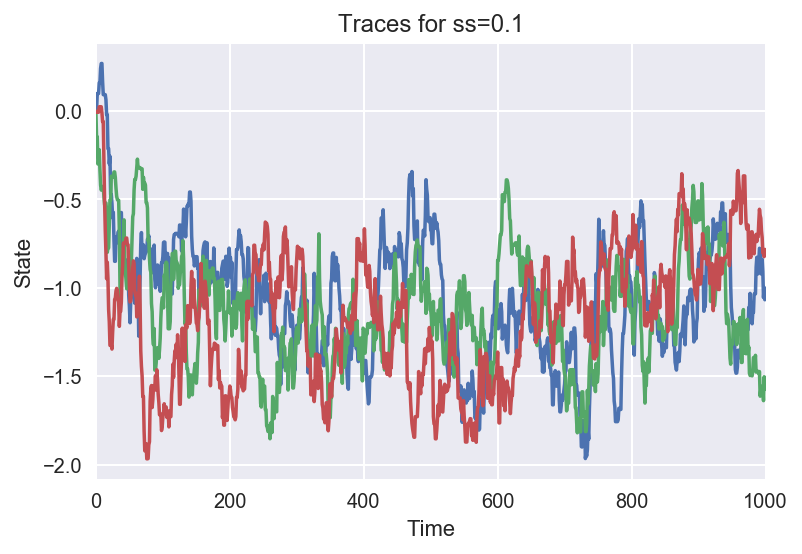

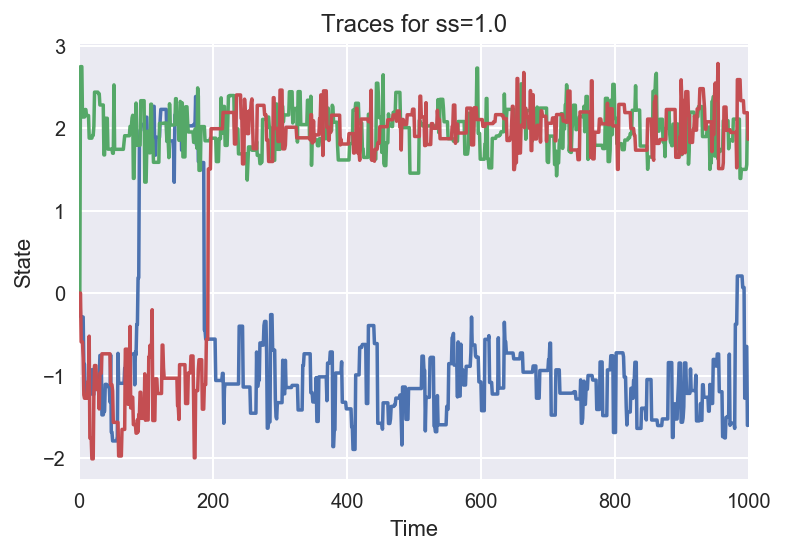

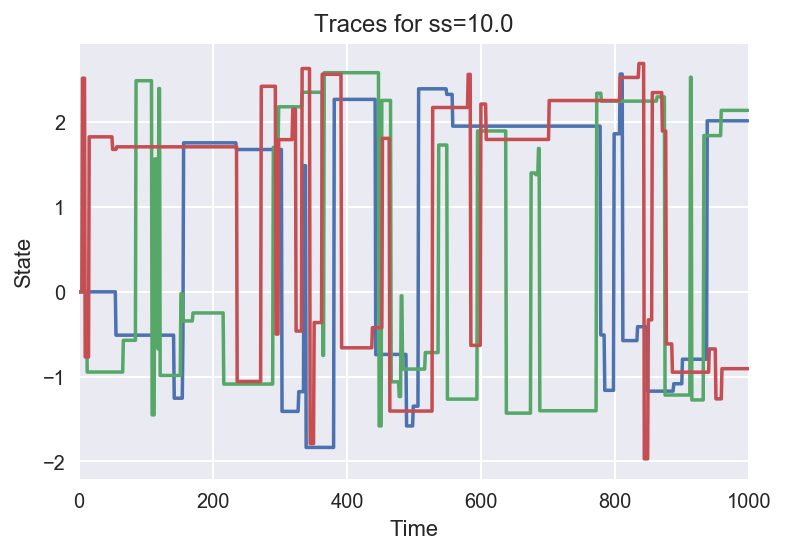

In [8]:
plot_trace(*s1, .1)
plot_trace(*s2, 1.)
plot_trace(*s3, 10.)

/Users/joe-davison/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


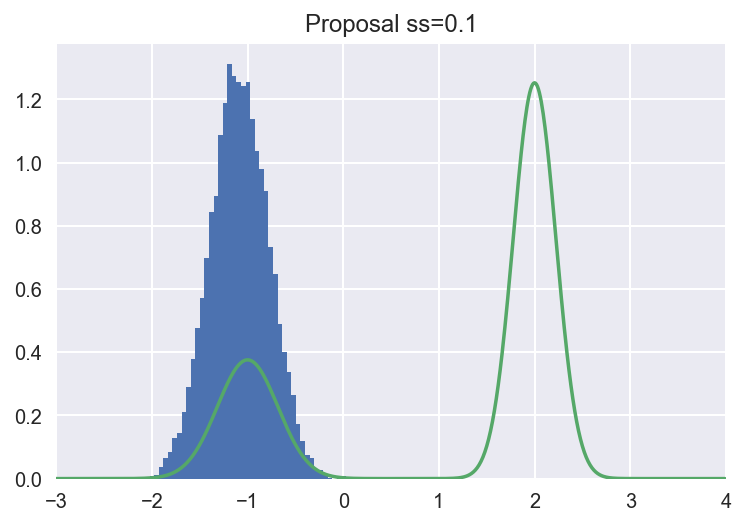

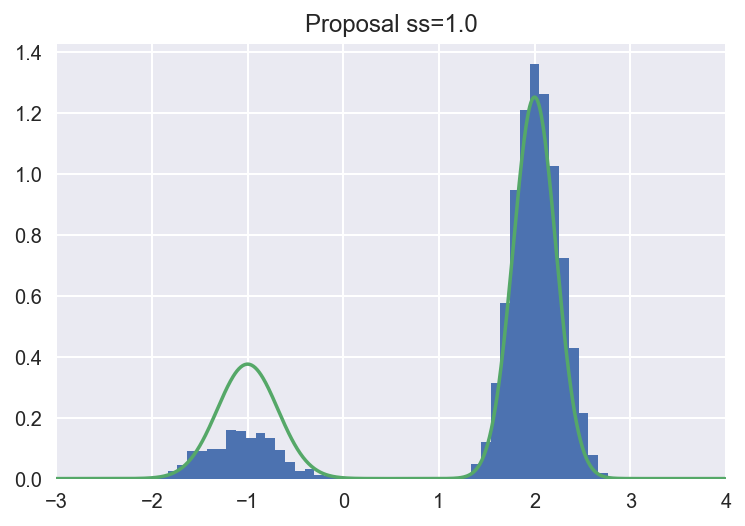

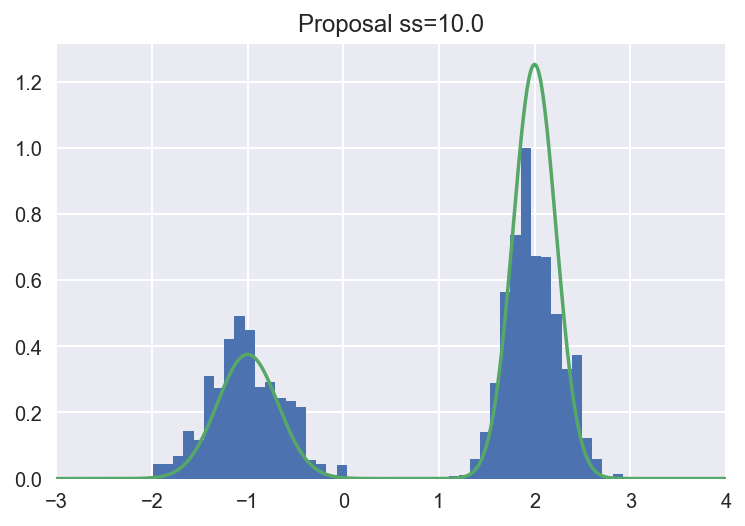

In [9]:
plot_samples(s1, .1)
plot_samples(s2, 1.)
plot_samples(s3, 10.)

### Part 2: Hamiltonian MCMC

In [12]:
from autograd import grad
import autograd.numpy as np

In [13]:
def hmc(p_density, epsilon, L, ss):
    u = lambda x: -np.log(p_density(x))
    accepted = []
    grad_u = grad(u)
    qs = [0.]
    for _ in range(10000):
        q = qs[-1]
        p = np.random.normal(0, ss)
        current_p = p

        p -= epsilon * grad_u(q) / 2.

        for i in range(L):
            q += epsilon * p
            if i is not L - 1:
                p -= epsilon * grad_u(q)

        p -= epsilon * grad_u(q) / 2.
        p *= -1

        current_u = u(qs[-1])
        current_k = np.sum(current_p**2) / 2.
        proposed_u = u(q)
        proposed_k = np.sum(p**2) / 2.

        alpha = np.exp(current_u - proposed_u + current_k - proposed_k)
        r = min(alpha, 1)
        randint = np.random.uniform(0, 1)
        qs.append((q if randint < r else qs[-1]))
        accepted.append(randint < r)
    print(np.array(accepted).mean())
    return qs

In [14]:
samples = hmc(p, epsilon=.35, L=5, ss=2.5)

0.6679


/Users/joe-davison/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


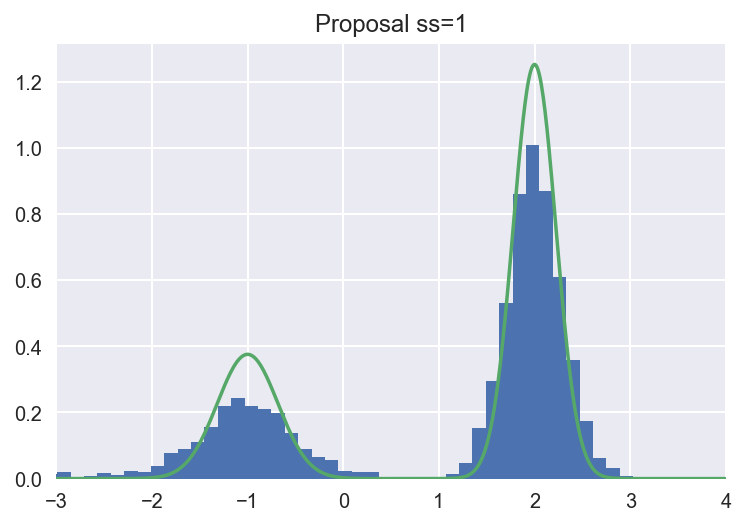

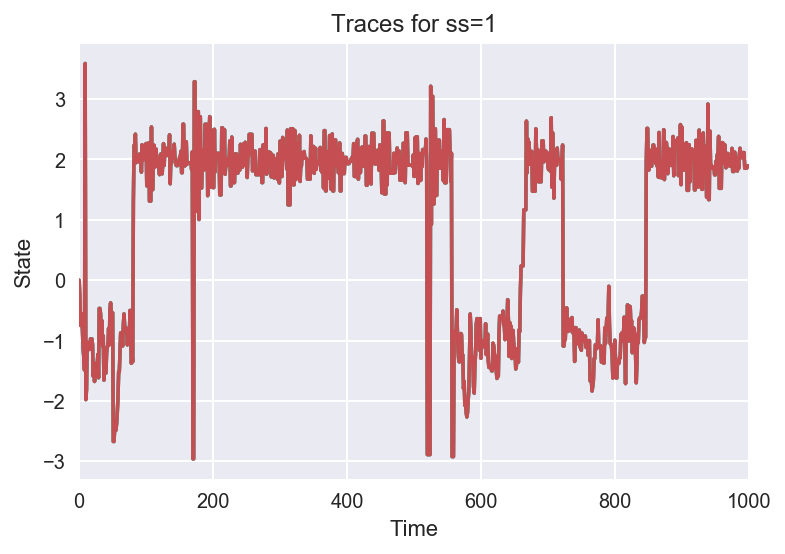

In [15]:
plot_samples(samples, 1)
plot_trace(samples, samples, samples, 1)

### Part 3: Observations

The two algorithms provide different ways of generating and accepting new states to look at. Metropolis Hastings has the advantage of simplicity but is also more prone to states being caught in local minimia, to speak in optimization terms. Adding the additional term of the momentum in Hamiltonian provides an opportunity to escape that while still sampling representatively from local high density areas. The down side is that it requires a little bit more work to tune and is more comlpex to use.

- What was the acceptance rate of each algorithm? (ie, what percentage of proposals were accepted)

The Hamiltonian version had an acceptance rate of 0.6778. For M-H, the acceptance rates were 87.22%, 24.44%, and 3.39%.

- Why don't some inference algorithms explore both modes of the density?

Because the states can get caught in areas of high probability density, similar to how a greedy optimization algorithm can get caught in local minima.

- Why do some algorithms stay in the same state repeatedly? Is this good or bad?

Because they have a lower acceptance rate — they are more reluctant to go from an area of high density to an area of low density. This is neither good nor bad. It depends on where the most room for error is in your sampling and your distribution itself. In other words, it depends.

- What were the best values for the variance of the momentum variables and the timestep you found? How did you know that they were good?

The best variables I found $\epsilon=0.35$ and $\sigma^2 = 2.5$. I knew they were good through a combination of experimentation and understanding of the role they play. Values of $\epsilon$ less than .3 or so caused too high of an acceptance rate which resulted in a lot of points sampled in areas of lower density. The value of .35 was just high enough to keep the sampled points representative of our distribution. I chose the value for $\sigma^2$ because lower values caused oversampling (or even exclusive sampling) from one of the two modes. I had to make the variance just big enough that the sampler could get between the modes without causing to broad of a variance in the overall sampling. I guaged all of these things by inspecting the visualizations and the average acceptance rates.